# Use case proposal

This notebooks propose a mapping between the fives steps of policy-making as theorized by Howlett and al. (2009) and text analysis methods enabling to extract valuable knowledge from text written by the citizens for each stage of the policy making process. The steps are the following :

- **Agenda-Setting** : Framing the problem and exploring the needs for a policy,
- **Formulation** : Developing policy options and informing them,
- **Decision** : Selection of the option among a range of options,
- **Implementation** : enactment of the passed policies through legislation, regulation, planning,
- **Monitoring** : Evaluation of the effects of passed policy

Each steps requires differents insight and, maybe, different methods of data mining in order to provide usefull information for the current steps of the process.


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import glob
import unidecode
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop

stop_words = list(fr_stop)+['qu', 'quelqu']

## The datasets 

Two dataset are used in this analysis : 
- **Reinventons Liège** : Contains suggestions and/or opinions of citizen about the future of their city, 
- **Twitter posts** : Contains tweets mentionning the city of liege or written in the boundaries of the city.

In [34]:
## Loading the data
DATA_FOLDER = "./data"

path = "{}/{}".format(DATA_FOLDER, "all_tweets.csv")
tweets = pd.read_csv(path)

## Loading participations data
path = "{}/{}".format(DATA_FOLDER, "reinventons-liege.csv")
reinventons = pd.read_csv(path, delimiter=";", header=0,  names=["cat","title", "pos", "neg", "desc"])

# Clean desc
clean = []
for i, row in reinventons.iterrows():
    text = row["desc"].replace('\r', ' ').replace('\n', ' ').replace(";", "")
    text = unidecode.unidecode(text).lower()
    clean.append(text)
reinventons["desc"] = clean

# LOG
print("Number of tweets {}".format(len(tweets)))
print("Number of citizens ideas (Réinventons Liège) {}".format(len(reinventons)))

Number of tweets 1962
Number of citizens ideas (Réinventons Liège) 988


## Agenda-Setting

The questions asked at this stage are *Is their issues requiering a new policies ?* or *What are the issues faced by the citizens ?*. In order to answer those questions, we need visualization able to provide information to the policy-makers

e.g : Hot topics

### Sources

https://www.sciencedirect.com/science/article/pii/S0196655315006148?casa_token=ZZExmN_H7IgAAAAA:DeRVB0xvT2BY3Ls1kMYsMghFHEFvltMEhXJHTenX1oueKV4IU9WKQpmEdoQCaLrQ7FqFyE8CRg

https://www.cs.toronto.edu/~jstolee/projects/topic.pdf

## Topic analysis 

https://ieeexplore.ieee.org/abstract/document/8034976

https://cbail.github.io/SICSS_Topic_Modeling.html

In [35]:
# Cleaning all the document tweets
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
nbr_topics = 35

cleaned_data = [x[1]["cleaned_text"] for x in tweets.iterrows()]

# Merging the liege "reinventons liege data"
cleaned_data += [x[1]["desc"] for x in reinventons.iterrows()]

cv = CountVectorizer(max_df = 0.95, min_df = 2, stop_words = stop_words)
vect = cv.fit_transform(cleaned_data)

lda = LatentDirichletAllocation(n_components = nbr_topics)
lda.fit(vect)

assigned_doc = lda.transform(vect)

def get_topic_name(idx, nbr_keywords):
    topic = lda.components_[idx]
    return [cv.get_feature_names()[i] for i in topic.argsort()[-nbr_keywords:]]

treshold = 0.7
dic_topic = {}
dic_topic["unasigned"] = []

for idx, elem in enumerate(assigned_doc):
    argmax = elem.argmax()
    
    if elem[argmax] > treshold:
        topicName = f'Topic #{argmax}'
        
        if topicName not in dic_topic.keys():
            dic_topic[topicName] = {
                "texts":[],
                "idx":[],
                "keywords": get_topic_name(argmax, 10)
            }
        
        
        dic_topic[topicName]["texts"].append(cleaned_data[idx])
        dic_topic[topicName]["idx"].append(idx)
    else:
        dic_topic["unasigned"].append(idx)
        


1962


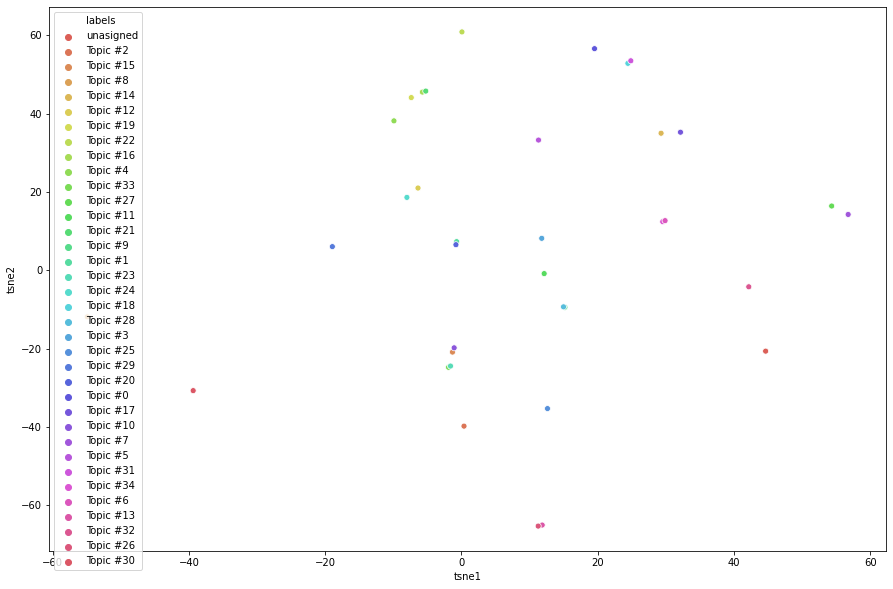

In [20]:
from sklearn.manifold import TSNE 

# create dataframe 
df_init = []
for elem in dic_topic:
    if elem != "unasigned":
        for idx in dic_topic[elem]["idx"]:
            d = {}
            d["full_text"] = tweets["full_text"][idx]
            d["vect"] = vect[idx]
            d["lda"] = assigned_doc[idx]
            d["label"] = elem
            d["keywords"] = dic_topic[elem]["keywords"]
            
    else:
        for idx in dic_topic[elem]:
            d = {}
            d["full_text"] = tweets["full_text"][idx]
            d["vect"] = vect[idx]
            d["lda"] = assigned_doc[idx]
            d["label"] = elem
            d["keywords"] = ["unasigned"]
    df_init.append(d)
    
df = pd.DataFrame.from_dict(df_init)

X_embedded = TSNE(n_components=2).fit_transform(assigned_doc)
print(len(X_embedded))

tsne = pd.DataFrame(X_embedded, columns =['tsne1', 'tsne2'])
tsne["labels"] = df["label"]
tsne["val"] = df["full_text"]

plt.figure(figsize=(15,10))
sns.scatterplot(x = "tsne1", y="tsne2", hue="labels", data=tsne, palette=sns.color_palette("hls", len(dic_topic.keys())))

In [ ]:
print(len(dic_topic["unasigned"]))
for elem in dic_topic:
    if elem == "unasigned":
        continue
        
    print(f'\n\n{elem}')
    print(f'{dic_topic[elem]["keywords"]}\n\n')
    
    for t in dic_topic[elem]["texts"][:15]:
        print(f'{t}\n')

In [36]:
# KMEANS

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

nbr_cluster = 30

def preprocessing(line):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    return line

vectorizer = TfidfVectorizer(stop_words=list(fr_stop)+['qu', 'quelqu'])
X = vectorizer.fit_transform(cleaned_data)


X_embedded = TSNE(n_components=2).fit_transform(X)
kmeans = KMeans(n_clusters=nbr_cluster).fit_predict(X)

# COSINE distance kmean
model = KMeansClusterer(nbr_cluster, nltk.cluster.util.cosine_distance, avoid_empty_clusters = True)
one_hot_vec = [freq.toarray()[0] for freq in X]
co_kmean = model.cluster(one_hot_vec, assign_clusters=True)

/home/jeromefink/.local/lib/python3.8/site-packages/nltk/cluster/util.py:131: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (numpy.dot(u, v) / (sqrt(numpy.dot(u, u)) * sqrt(numpy.dot(v, v))))


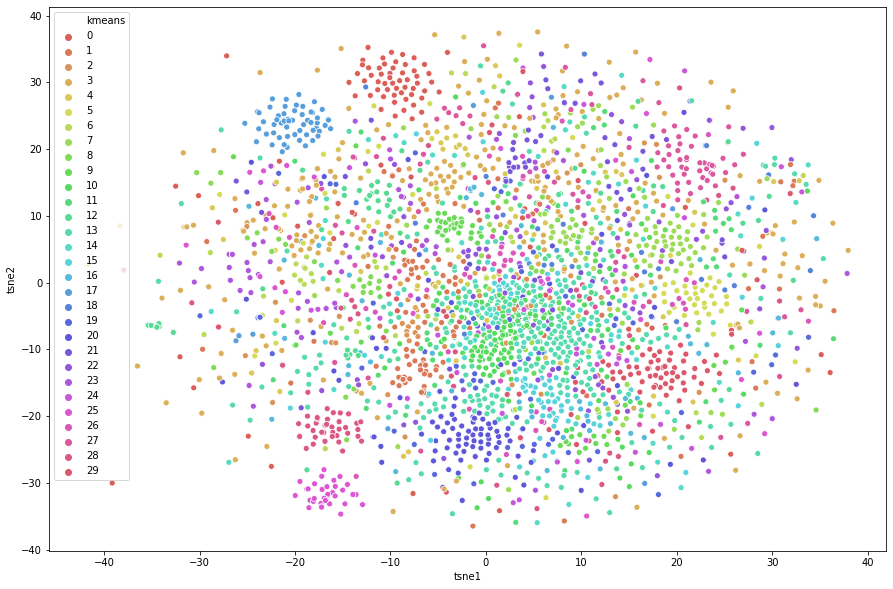

In [37]:
tsne = pd.DataFrame(X_embedded, columns =['tsne1', 'tsne2'])
tsne["kmeans"] = co_kmean
tsne["val"] = cleaned_data

plt.figure(figsize=(15,10))
sns.scatterplot(x = "tsne1", y="tsne2", hue="kmeans", data=tsne, palette=sns.color_palette("hls", nbr_cluster))

In [41]:
for i in range(nbr_cluster):
    print("\n\n\n=======================================================")
    print("CLUSTER {}".format(i))
    print("=======================================================\n\n\n")
    
    for j, row in tsne.iterrows():
        if row["kmeans"] == i:
            print(row["val"] + "\n")
            print("------\n")
            
tsne.to_csv("./results.csv")




CLUSTER 0



Et toi, quelle heure est-il sur ton bijoux [][] ( by stephanegerald2 &amp; justintouvor ) ekstoreonline a Liege, Belgium

------

<< Copilot and the City >> girlatwork daughterempowerment TitiAllStars SunGlasses a Liege, Belgium

------

Liege, saint Martin et le boulevard de la Sauveniere Liege blackandwhitephotography NightPhotography Belgium Photos -&gt;

------

J-M Namotte <<On devra tirer des enseignements de cette crise, redessiner des accords entre les interlocuteurs sociaux, relocaliser une serie d'entreprises, consommer autrement, renforcer la securite sociale" via lavenir net

------

Lommel rsca po2 ABraeckman Tracasse Nos "unes" Vos unes

------

Covid-19 une nouvelle technique de l'universite de Liege pour tester 10000 a 20000 personnes par jour en Belgique

------

Covid-19 une nouvelle technique de l&amp;039;universite de Liege pour tester 10000 a 20000 personnes par jour en Belgique via TodayinliegeBe

------

Merci qui Merci ULiege Covid-19 une nouvell

## Formulation 

Once the need of a policy is identified, solutions must be found in order to adress the issue. 

At this points we need to merge the various datasets and perform clustering analysis on them. We begin with documents filtered at the previous step as an input for this step. The clustering could classify the various solutions proposed by the citizens

e.g : analyze discussions about the issue

In [ ]:
# Focus on one of the topic. Design keywords etc in order to select the interesting stuff


## Decision

Once all the options are formulated, the policy makers needs to chose one (ideally the best one).
Heavily linked to the "Formulation" pĥase. 

e.g : Which solution is more engaging for the citizens

## Implementation

Setting up the solution. 

## Monitoring

Evaluate the effect of the implemented solution in order to see if the issue was solved or if there are side-effects.

e.g : Hot topics analysis but on a specifica subset of tweets concerning the policy implemented 